In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from xgboost import XGBRegressor
import math
import plotly.graph_objs as go
import chart_studio.plotly as py
from collections import defaultdict
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
def scale(x):
    return (x - x.mean())/x.std()

In [3]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

# 海康威视

## 1. Load Data

In [4]:
hkws_path = 'D:/DeskTop-Files/CUHK-SZ/2022-2023 Fall term/1-Wed-14~17-IBA6 Fintech and Application/Group_final/stock_chosen/stock_chosen/data_prepocessed/海康威视_002415_成长.xlsx'
df = pd.DataFrame(pd.read_excel(hkws_path))
df.head()

,日期,股价,前收盘价(元),开盘价(元),最高价(元),最低价(元),收盘价(元),成交量(股),成交金额(元),涨跌(元),...,宏观_PPI,宏观_出口价格指数(总),宏观_出口价格指数(车船航),宏观_进口价格指数(总),宏观_进口价格指数(车船航),宏观_固定资产投资完成额,宏观_社会消费品零售总额,宏观_M2,宏观_金融机构各项贷款余额,宏观_社会融资规模
0,2016-01-08,29.25,-0.606953,-0.507542,-0.506968,-0.588521,-0.515301,-0.929499,-0.977194,1.165927,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
1,2016-01-11,28.93,-0.515462,-0.547978,-0.530519,-0.657445,-0.679977,-0.907597,-0.973743,-2.140483,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
2,2016-01-12,28.51,-0.680146,-0.635589,-0.668062,-0.676154,-0.710794,-0.986151,-1.050495,-0.412697,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
3,2016-01-13,29.36,-0.710964,-0.672174,-0.703861,-0.726370,-0.751241,-1.180293,-1.198319,-0.536998,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
4,2016-01-14,28.29,-0.751412,-0.798296,-0.709513,-0.785448,-0.669384,-0.914004,-1.011334,1.041625,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0


In [5]:
# Plot with plotly
data = [go.Scatter(
            x = df['日期'],
            y = df['股价'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'DATE'),
              yaxis = dict(title = 'STOCK PRICE'))

fig = dict(data=data, layout=layout)
py.iplot(fig)

## 2. Data Preprocessing 

In [6]:
df1 = df[['股价','宏观_CPI', '宏观_PPI', '宏观_出口价格指数(总)',
       '宏观_出口价格指数(车船航)', '宏观_进口价格指数(总)',
       '宏观_进口价格指数(车船航)', '宏观_固定资产投资完成额', '宏观_社会消费品零售总额',
       '宏观_M2', '宏观_金融机构各项贷款余额', '宏观_社会融资规模']].apply(scale,axis=0)

df[['股价','宏观_CPI', '宏观_PPI', '宏观_出口价格指数(总)',
       '宏观_出口价格指数(车船航)', '宏观_进口价格指数(总)',
       '宏观_进口价格指数(车船航)', '宏观_固定资产投资完成额', '宏观_社会消费品零售总额',
       '宏观_M2', '宏观_金融机构各项贷款余额', '宏观_社会融资规模']] = df1

In [7]:
df

,日期,股价,前收盘价(元),开盘价(元),最高价(元),最低价(元),收盘价(元),成交量(股),成交金额(元),涨跌(元),...,宏观_PPI,宏观_出口价格指数(总),宏观_出口价格指数(车船航),宏观_进口价格指数(总),宏观_进口价格指数(车船航),宏观_固定资产投资完成额,宏观_社会消费品零售总额,宏观_M2,宏观_金融机构各项贷款余额,宏观_社会融资规模
0,2016-01-08,-0.667776,-0.606953,-0.507542,-0.506968,-0.588521,-0.515301,-0.929499,-0.977194,1.165927,...,-1.830613,-0.700998,-0.278554,-1.226070,-0.118880,-0.840997,-0.825414,2.817632,2.957543,1.017143
1,2016-01-11,-0.698001,-0.515462,-0.547978,-0.530519,-0.657445,-0.679977,-0.907597,-0.973743,-2.140483,...,-1.830613,-0.700998,-0.278554,-1.226070,-0.118880,-0.840997,-0.825414,2.817632,2.957543,1.017143
2,2016-01-12,-0.737671,-0.680146,-0.635589,-0.668062,-0.676154,-0.710794,-0.986151,-1.050495,-0.412697,...,-1.830613,-0.700998,-0.278554,-1.226070,-0.118880,-0.840997,-0.825414,2.817632,2.957543,1.017143
3,2016-01-13,-0.657386,-0.710964,-0.672174,-0.703861,-0.726370,-0.751241,-1.180293,-1.198319,-0.536998,...,-1.830613,-0.700998,-0.278554,-1.226070,-0.118880,-0.840997,-0.825414,2.817632,2.957543,1.017143
4,2016-01-14,-0.758450,-0.751412,-0.798296,-0.709513,-0.785448,-0.669384,-0.914004,-1.011334,1.041625,...,-1.830613,-0.700998,-0.278554,-1.226070,-0.118880,-0.840997,-0.825414,2.817632,2.957543,1.017143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,2022-11-25,-0.561990,-0.492349,-0.489249,-0.510736,-0.474303,-0.521079,-0.680249,-0.773634,-0.387837,...,-0.919710,1.075648,1.065966,0.523859,-0.210383,0.005121,-0.892006,1.374933,-1.850554,-1.150062
1674,2022-11-28,-0.442035,-0.521241,-0.633663,-0.556898,-0.605260,-0.572119,0.072797,-0.212363,-0.673730,...,-0.919710,1.075648,1.065966,0.523859,-0.210383,0.005121,-0.892006,1.374933,-1.850554,-1.150062
1675,2022-11-29,-0.454314,-0.572283,-0.568196,-0.480590,-0.521566,-0.449816,0.141222,-0.113179,1.563690,...,-0.919710,1.075648,1.065966,0.523859,-0.210383,0.005121,-0.892006,1.374933,-1.850554,-1.150062
1676,2022-11-30,-0.403310,-0.449974,-0.451701,-0.435370,-0.437872,-0.462335,-0.072013,-0.268738,-0.176525,...,-0.919710,1.075648,1.065966,0.523859,-0.210383,0.005121,-0.892006,1.374933,-1.850554,-1.150062


In [8]:
y = df[["股价"]].copy()
df["target"] = y.shift(-1)
df.dropna(inplace=True)
df = df.drop(['日期'], axis=1)
y = df['target']
X = df.drop('target', axis=1) 

## 3. PCA

In [9]:
n = X.shape[1]
x=np.transpose(np.mat((np.arange(n)+1)))

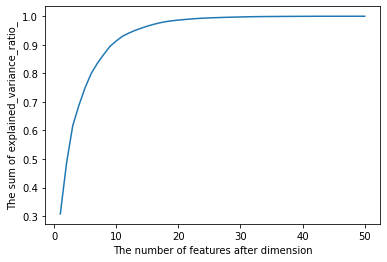

In [10]:
pca = PCA().fit(X)  # 默认n_components为特征数目4
pca_info = pca.explained_variance_ratio_
# print("每个特征在原始数据信息占比：\n", pca_info)
pca_info_sum = np.cumsum(pca_info)
# print("前i个特征总共在原始数据信息占比：\n", pca_info_sum)

plt.plot(x, pca_info_sum)  # [1, 2, 3, 4]表示选1个特征、2个特征...
#plt.xticks([1, 2, 3, 4])  # 限制坐标长度
plt.xlabel('The number of features after dimension')
plt.ylabel('The sum of explained_variance_ratio_')
plt.show()

In [11]:
pca = PCA(n_components=0.95, svd_solver='full')
pca = pca.fit(X)
pca_new = pca.transform(X)
print(pca_new.shape)
print(pca.explained_variance_ratio_.sum())

(1677, 13)
0.9502434457079344


## 4. Split train set，validation set and test set 

In [12]:
from sklearn.model_selection import train_test_split
X_train_val,X_test,y_train_val,y_test = train_test_split(pca_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 1/9, random_state = 42)
print("train.shape = " + str(X_train.shape))
print("val.shape = " + str(X_val.shape))
print("train_val.shape = " + str(X_train_val.shape))
print("test.shape = " + str(X_test.shape))

train.shape = (1341, 13)
val.shape = (168, 13)
train_val.shape = (1509, 13)
test.shape = (168, 13)


## 5. XGBOOST

In [13]:
def xgb_model_train_val(X_train, y_train, X_val, y_val,
                          seed=100, n_estimators=100, max_depth=3, learning_rate=0.1,
                          min_child_weight=1, subsample=1, colsample_bytree=1, colsample_bylevel=1, gamma=0):

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=seed, n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_val, est)
    mape = get_mape(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mape, mae, est, model, model.feature_importances_

In [14]:
def xgb_model_test_eval(X_test, y_test, model):
    
    # Get predicted labels
    est = model.predict(X_test)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est

### 1) Prediction before tuning on validation set

In [15]:
# Get error metrics on validation set before hyperparameter tuning
xgb_rmse_bef_tuning, xgb_mape_bef_tuning, xgb_mae_bef_tuning, xgb_preds,xgb_model_bef_tuning,xgb_f = xgb_model_train_val(X_train, y_train, X_val, y_val)
                                                                
print("RMSE = %0.3f" % xgb_rmse_bef_tuning)
print("MAPE = %0.3f%%" % xgb_mape_bef_tuning)
print("MAE = %0.3f%" % xgb_mae_bef_tuning)

RMSE = 0.138
MAPE = 44.071%
MAE = 0.095%


### 2) Tuning parameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [16]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = range(40, 60, 2)

param2_label = 'max_depth'
param2_list = [4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = xgb_model_train_val(X_train, y_train, X_val, y_val,
                                                            seed = 100,n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-16-320138744be0>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.27


,n_estimators,max_depth,rmse,mape,mae
0,40,4,0.135291,41.114570,0.094912
1,40,5,0.130927,37.876930,0.089727
2,40,6,0.131205,33.558863,0.089218
3,40,7,0.130989,32.628544,0.088617
4,40,8,0.127028,29.674693,0.087363
5,40,9,0.130540,30.112137,0.088637
6,42,4,0.134131,40.695868,0.093547
7,42,5,0.130202,37.905982,0.088952
8,42,6,0.130551,33.040174,0.088681
9,42,7,0.129882,32.452544,0.087776


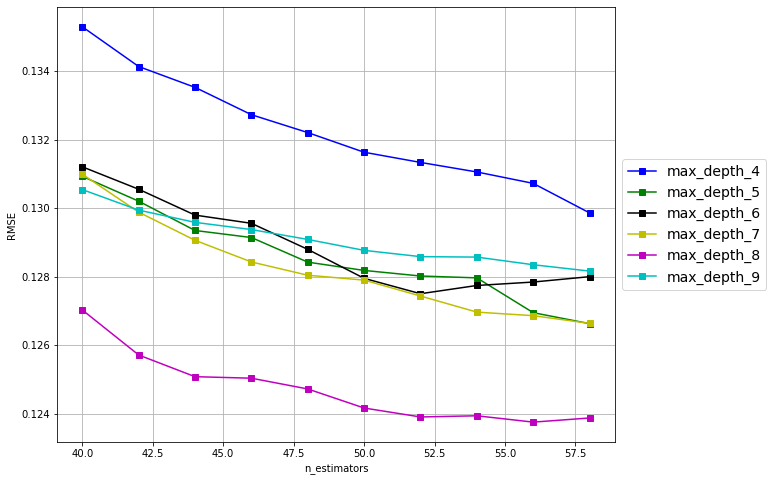

In [17]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [18]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.124
optimum params = 


(56, 8)

In [19]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 29.452%
optimum params = 


(42, 8)

#### Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [20]:
param_label = 'learning_rate'
param_list = [ 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 15, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-20-90480c513b81>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 0.26


,learning_rate,min_child_weight,rmse,mape,mae
0,0.01,5,0.650825,158.225611,0.571537
1,0.01,6,0.651393,158.325078,0.571640
2,0.01,7,0.651546,157.813967,0.571909
3,0.01,8,0.651622,157.215534,0.571934
4,0.01,9,0.651396,157.225199,0.571149
5,0.01,10,0.650228,156.628863,0.569892
6,0.01,11,0.650412,155.761759,0.569701
7,0.01,12,0.650511,154.881831,0.569669
8,0.01,13,0.650972,154.672221,0.570341
9,0.01,14,0.651002,154.867197,0.570214


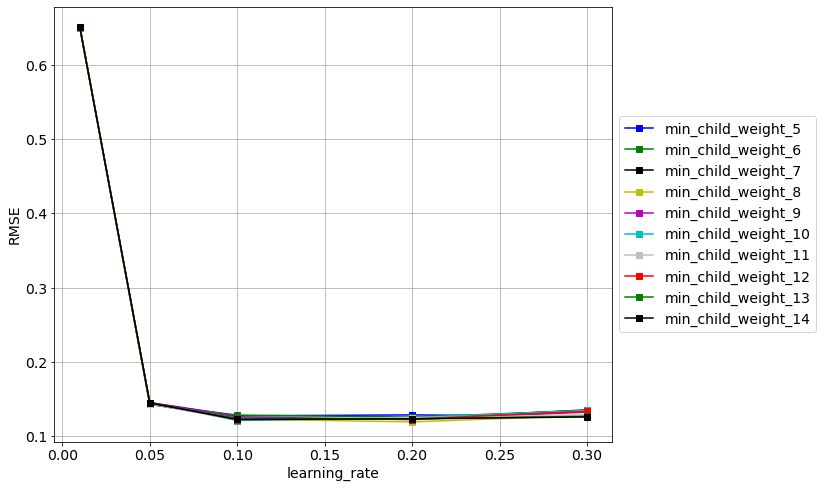

In [21]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [22]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.119
optimum params = 


(0.2, 8)

In [23]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 27.619%
optimum params = 


(0.1, 10)

#### Tuning subsample(default=1) and gamma(default=0)

In [24]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-24-dbde90e851ed>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.57


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,0.171956,49.409210,0.122668
1,0.1,0.1,0.157406,50.732030,0.117404
2,0.1,0.2,0.171821,60.962961,0.126888
3,0.1,0.3,0.177463,69.257554,0.130106
4,0.1,0.4,0.177402,70.844620,0.127741
...,...,...,...,...,...
105,1.0,0.6,0.147131,40.115178,0.105865
106,1.0,0.7,0.155446,42.668885,0.111604
107,1.0,0.8,0.156092,44.202375,0.112017
108,1.0,0.9,0.155338,46.232177,0.111760


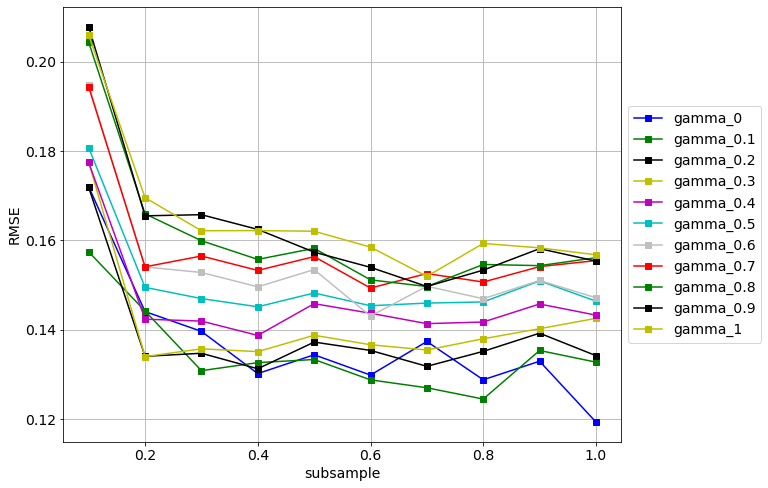

In [25]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [26]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.119
optimum params = 


(1.0, 0.0)

In [27]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 32.159%
optimum params = 


(0.9, 0.0)

#### Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [28]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-28-c4c507cb89e8>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 0.19


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,0.236754,57.526420,0.165646
1,0.5,0.6,0.236754,57.526420,0.165646
2,0.5,0.7,0.235774,64.452638,0.172534
3,0.5,0.8,0.235774,64.452638,0.172534
4,0.5,0.9,0.232701,61.512604,0.156568
5,0.5,1.0,0.226480,56.984568,0.158255
6,0.6,0.5,0.174760,48.184174,0.125302
7,0.6,0.6,0.169634,41.472000,0.120878
8,0.6,0.7,0.169634,41.472000,0.120878
9,0.6,0.8,0.188253,39.930191,0.127237


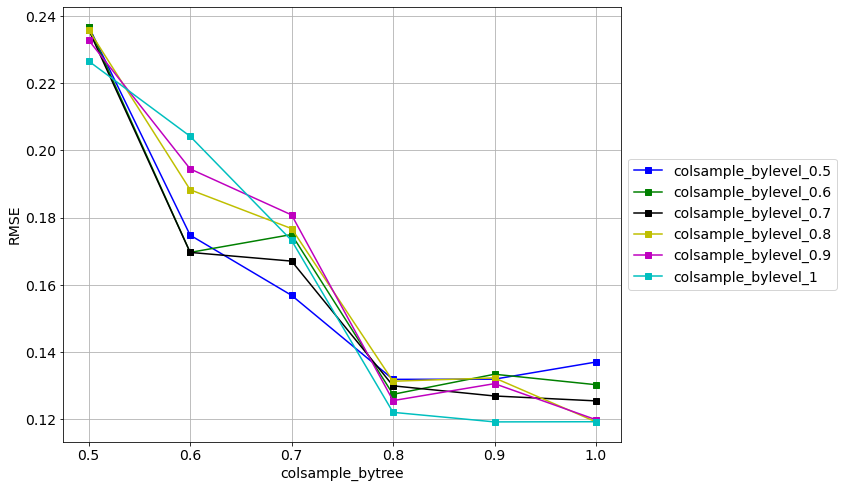

In [29]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [30]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.119
optimum params = 


(0.9, 1.0)

In [31]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 29.242%
optimum params = 


(1.0, 0.7)

#### Final model

In [32]:
# Get error metrics on validation set after hyperparameter tuning
xgb_rmse_aft_tuning, xgb_mape_aft_tuning, xgb_mae_aft_tuning, xgb_preds,xgb_model_aft_tuning,f = \
                                                                        xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % xgb_rmse_aft_tuning)
print("MAPE = %0.3f%%" % xgb_mape_aft_tuning)
print("MAE = %0.3f" % xgb_mae_aft_tuning)

RMSE = 0.119
MAPE = 31.603%
MAE = 0.085


#### Tuned params

In [34]:
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0 

In [35]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, xgb_rmse_bef_tuning, xgb_mape_bef_tuning, xgb_mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, xgb_rmse_aft_tuning, xgb_mape_aft_tuning, xgb_mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,56.000
1,max_depth,3.000,8.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,8.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.000
8,val_rmse,0.138,0.119
9,val_mape,44.071,31.603


### 3) Prediction after tuning

In [36]:
# Do prediction on test set
xgb_test_rmse_aft_tuning, xgb_test_mape_aft_tuning, xgb_test_mae_aft_tuning,xgb_pred = xgb_model_test_eval(X_test, y_test,xgb_model_aft_tuning)

print("RMSE = %0.3f" % xgb_test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % xgb_test_mape_aft_tuning)
print("MAE = %0.3f" % xgb_test_mae_aft_tuning)

RMSE = 0.123
MAPE = 51.711%
MAE = 0.086


## 6. Random Forest

In [37]:
def rf_model_train_val(X_train, y_train, X_val, y_val,
                          n_estimators=100, 
                          max_depth=3, 
                          min_samples_split=2,
                          min_samples_leaf=1):

    model = RandomForestRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                          min_samples_split=min_samples_split,
                          min_samples_leaf=min_samples_leaf)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_val, est)
    mape = get_mape(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mape, mae, est, model, model.feature_importances_

In [38]:
def rf_model_test_eval(X_test, y_test, model):
    
    # Get predicted labels
    est = model.predict(X_test)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est

### 1) Tuning aprameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [39]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = range(40, 60, 2)

param2_label = 'max_depth'
param2_list = range(45,49,1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                            n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-39-80ecb1d7b3ea>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.29


,n_estimators,max_depth,rmse,mape,mae
0,40,45,0.122267,35.836083,0.084477
1,40,46,0.124592,34.284835,0.085062
2,40,47,0.124157,32.356056,0.085142
3,40,48,0.130632,38.503230,0.088507
4,42,45,0.124419,34.076839,0.085306
5,42,46,0.118934,29.227681,0.082241
6,42,47,0.123304,33.825373,0.085191
7,42,48,0.125072,32.371897,0.085101
8,44,45,0.126258,34.713584,0.087697
9,44,46,0.121362,32.493345,0.086480


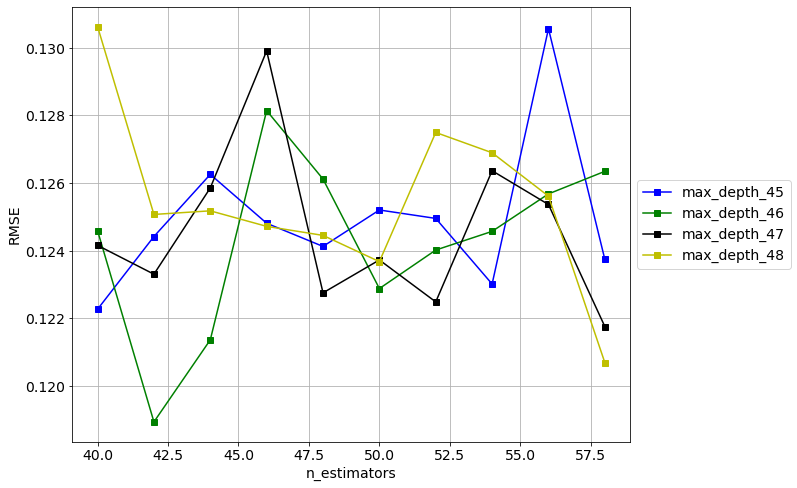

In [40]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [41]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.119
optimum params = 


(42, 46)

In [42]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 29.228%
optimum params = 


(42, 46)

#### Tuning min_samples_split(default=2) and  min_samples_leaf(default=1)

In [43]:
from tqdm import tqdm_notebook
param_label = 'min_samples_split'
param_list = range(2, 5)

param2_label = 'min_samples_leaf'
param2_list = range(1,10)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean,pred,m,f = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                                    n_estimators=n_estimators_opt,
                                                                     max_depth=max_depth_opt,
                                                                    min_samples_split=param,
                                                                    min_samples_leaf=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-43-5630c3de8bbf>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

Minutes taken = 0.14


,min_samples_split,min_samples_leaf,rmse,mape,mae
0,2,1,0.124169,34.048889,0.085093
1,2,2,0.125825,35.045984,0.087164
2,2,3,0.132406,34.401419,0.089470
3,2,4,0.129961,33.260613,0.086846
4,2,5,0.133132,39.064617,0.090951
5,2,6,0.134937,39.139185,0.092614
6,2,7,0.132953,38.171213,0.090339
7,2,8,0.137501,40.055289,0.092560
8,2,9,0.136950,45.639297,0.092578
9,3,1,0.129929,34.537787,0.088665


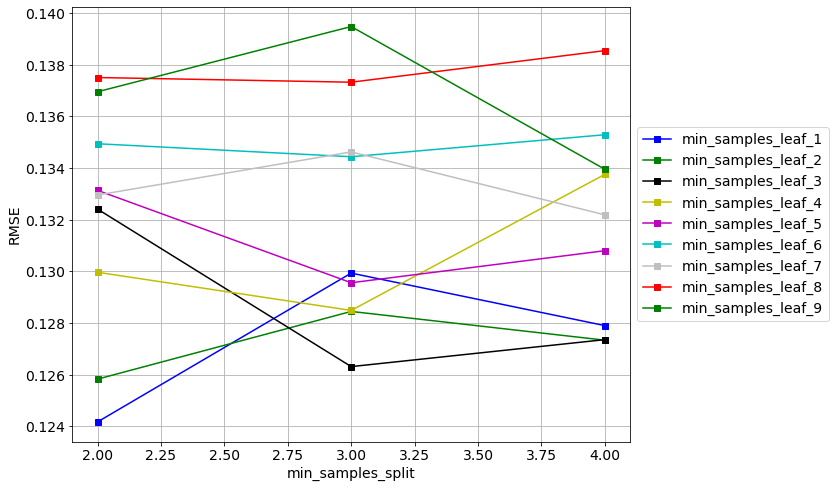

In [44]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [45]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
min_samples_split_opt = temp['min_samples_split'].values[0]
min_samples_leaf_opt = temp['min_samples_leaf'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
min_samples_split_opt, min_samples_leaf_opt

min RMSE = 0.124
optimum params = 


(2, 1)

In [46]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['min_samples_split'].values[0], temp['min_samples_leaf'].values[0]

min MAPE = 31.997%
optimum params = 


(3, 2)

#### Final Model

In [47]:
# Get error metrics on validation set after hyperparameter tuning
rf_rmse_aft_tuning, rf_mape_aft_tuning, rf_mae_aft_tuning, rf_preds,rf_model_aft_tuning,rf_f = \
                                                                        rf_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,                                                                        
                                                                        min_samples_split=min_samples_split_opt,
                                                                        min_samples_leaf=min_samples_leaf_opt)
print("RMSE = %0.3f" % rf_rmse_aft_tuning)
print("MAPE = %0.3f%%" % rf_mape_aft_tuning)
print("MAE = %0.3f" % rf_mae_aft_tuning)

RMSE = 0.118
MAPE = 32.475%
MAE = 0.084


In [48]:
# Do prediction on test set
rf_test_rmse_aft_tuning, rf_test_mape_aft_tuning, rf_test_mae_aft_tuning,rf_pred = rf_model_test_eval(X_test, y_test,rf_model_aft_tuning)

print("RMSE = %0.3f" % rf_test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % rf_test_mape_aft_tuning)
print("MAE = %0.3f" % rf_test_mae_aft_tuning)

RMSE = 0.125
MAPE = 51.230%
MAE = 0.089


## 7. Model comparison

In [53]:
# Tuned params and before and after error metrics
c = {'XGBOOST_validation': [ xgb_rmse_aft_tuning, xgb_mape_aft_tuning, xgb_mae_aft_tuning],
     'Random Forest_validation': [rf_rmse_aft_tuning, rf_mape_aft_tuning, rf_mae_aft_tuning],
     'XGBOOST_test': [ xgb_test_rmse_aft_tuning, xgb_test_mape_aft_tuning, xgb_test_mae_aft_tuning],
     'Random Forest_test': [rf_test_rmse_aft_tuning, rf_test_mape_aft_tuning, rf_test_mae_aft_tuning],}
comparison = pd.DataFrame(c)
comparison.index = ['RMSE','MAPE','MAE']
comparison = comparison.round(3)
comparison

,XGBOOST_validation,Random Forest_validation,XGBOOST_test,Random Forest_test
RMSE,0.119,0.118,0.123,0.125
MAPE,31.603,32.475,51.711,51.230
MAE,0.085,0.084,0.086,0.089
